# Depression Predictor

## Import packages

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import AveragePooling2D, Conv2D, Dense, Flatten, Reshape, ZeroPadding2D
from keras.utils import to_categorical

## Load data

In [128]:
data = pd.read_csv('data/emotion-detection/icml_face_data.csv/icml_face_data.csv')
data = data.rename(columns={' Usage': 'Usage', ' pixels': 'pixels'})  # Somehow column names conatin a leading space

## Take a quick look at the data structure

In [129]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [131]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


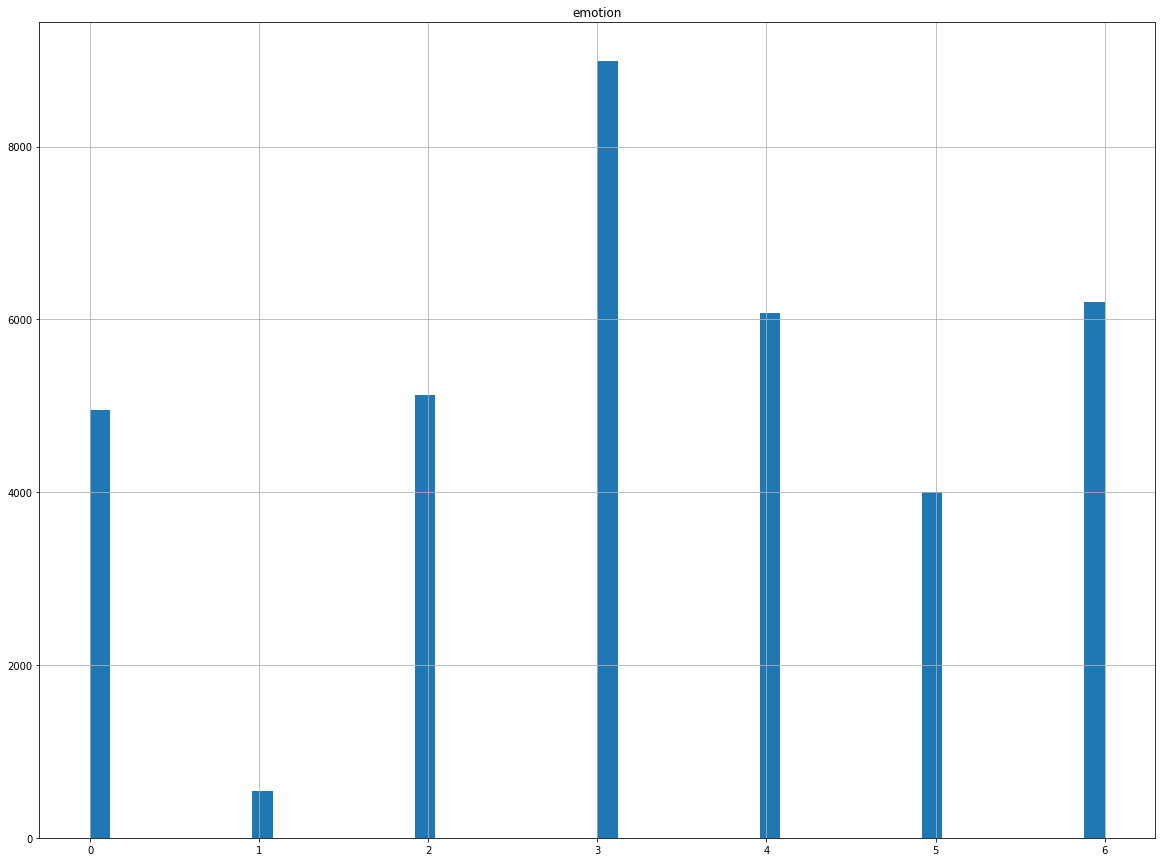

In [132]:
data.hist(bins=50, figsize=(20, 15))
plt.show()

## Set aside a test set

In [133]:
full_train_set = data[data['Usage']=='Training']
test_set = data[data['Usage']=='PrivateTest']
print(len(full_train_set), 'train istances +', len(test_set), 'test instances')

28709 train istances + 3589 test instances


## Prepare the data for model training

In [134]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].str.strip('"').str.split(pat=' ', expand=True).values

pipeline = Pipeline([
    ('selector', DataFrameSelector('pixels')),
    ('std_scaler', StandardScaler()),
])

full_train_X = pipeline.fit_transform(full_train_set)
full_train_y = np.array(full_train_set['emotion'])

## Train, select and fine-tune a model

In [135]:
# Choose and config a model
model_hyper_parameters = {
    'decision-tree': {
        'random_state': 0,
        'max_depth': 20,
        'min_samples_split': 50,
        'min_samples_leaf': 25,
    },
    'ada-boost': {
        'random_state': 0,
        'n_estimators': 50,
        'base_estimator': {
            'max_depth': 20,
            'min_samples_split': 50,
            'min_samples_leaf': 25,
            'max_features': 'sqrt',
        },
    },
    'neural-network': {
        'compiler': {
            'loss': 'categorical_crossentropy',
            'optimizer': 'adam',
            'metrics': ['accuracy'],
        },
        'epochs': 100,
        'batch_size': 1000,
        'verbose': 1,
    },
}
model_name = 'neural-network'

In [136]:
def construct_neural_network_model():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Reshape((48, 48, 1), input_shape=(2304,)))
    clf.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    clf.add(AveragePooling2D())
    clf.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    clf.add(AveragePooling2D())
    clf.add(Flatten())
    clf.add(Dense(units=120, activation='relu'))
    clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**model_hyper_parameters[model_name]['compiler'])
    clf.summary()
    return clf

def fit_and_validate_model(model_name):
    # Construct the model
    if model_name == 'decision-tree':
        clf = DecisionTreeClassifier(**model_hyper_parameters[model_name])
    elif model_name == 'ada-boost':
        base_estimator = DecisionTreeClassifier(**model_hyper_parameters[model_name]['base_estimator'])
        del model_hyper_parameters[model_name]['base_estimator']
        clf = AdaBoostClassifier(base_estimator=base_estimator, **model_hyper_parameters[model_name])
    elif model_name == 'neural-network':
        clf = construct_neural_network_model()
    else:
        raise ValueError('Invalid model specified!')
    
    # K-fold cross validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    train_accuracies, validation_accuracies = [], []
    training_history = None
    for train_index, validation_index in skf.split(full_train_X, full_train_y):
        train_X, validation_X = full_train_X[train_index], full_train_X[validation_index]
        train_y, validation_y = full_train_y[train_index], full_train_y[validation_index]
        # Fit the model
        if model_name == 'neural-network':
            clf = construct_neural_network_model()  # Re-construct model for each fold to avoid model warm starting
            categorical_train_y = to_categorical(train_y, 7)
            categorical_validation_y = to_categorical(validation_y, 7)
            training_history = clf.fit(
                train_X, categorical_train_y,
                validation_data=([validation_X], [categorical_validation_y]),
                epochs=model_hyper_parameters[model_name]['epochs'],
                batch_size=model_hyper_parameters[model_name]['batch_size'],
            )
        else:
            clf.fit(train_X, train_y)
        # Calculate train accuracy
        if model_name == 'neural-network':
            pred_y = clf.predict_classes(
                train_X,
                batch_size=model_hyper_parameters[model_name]['batch_size'],
                verbose=model_hyper_parameters[model_name]['verbose'],
            )
            pred_y = np.argmax(to_categorical(pred_y), axis=1)
        else:
            pred_y = clf.predict(train_X)
        train_accuracies.append(accuracy_score(train_y, pred_y))
        # Calculate validation accuracy
        if model_name == 'neural-network':
            pred_y = clf.predict_classes(
                validation_X,
                batch_size=model_hyper_parameters[model_name]['batch_size'],
                verbose=model_hyper_parameters[model_name]['verbose'],
            )
            pred_y = np.argmax(to_categorical(pred_y), axis=1)
        else:
            pred_y = clf.predict(validation_X)
        validation_accuracies.append(accuracy_score(validation_y, pred_y))
        
        # Neural network training is super time-consuming; hence, break after one fold cross validation is done
        if model_name == 'neural-network':
            break
    
    mean_train_accuracy = np.mean(train_accuracies)
    mean_validation_accuracy = np.mean(validation_accuracies)
    
    return clf, mean_train_accuracy, mean_validation_accuracy, training_history

# Fit and validate model
clf, mean_train_auc, mean_validation_auc, training_history = fit_and_validate_model(model_name)

# Print metrics on train set
print('Mean train AUC: {}'.format(mean_train_auc))

# Print metrics on validation set
print('Mean validation AUC: {}'.format(mean_validation_auc))

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 46, 46, 6)         60        
_________________________________________________________________
average_pooling2d_60 (Averag (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 21, 21, 16)        880       
_________________________________________________________________
average_pooling2d_61 (Averag (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 120)             

23/23 [==============================] - 4s 182ms/step - loss: 0.8419 - accuracy: 0.6977 - val_loss: 1.5430 - val_accuracy: 0.4767
Epoch 37/100
23/23 [==============================] - 4s 185ms/step - loss: 0.8156 - accuracy: 0.7094 - val_loss: 1.5687 - val_accuracy: 0.4720
Epoch 38/100
23/23 [==============================] - 4s 184ms/step - loss: 0.8090 - accuracy: 0.7118 - val_loss: 1.5969 - val_accuracy: 0.4803
Epoch 39/100
23/23 [==============================] - 4s 184ms/step - loss: 0.7880 - accuracy: 0.7179 - val_loss: 1.5858 - val_accuracy: 0.4777
Epoch 40/100
23/23 [==============================] - 4s 182ms/step - loss: 0.7499 - accuracy: 0.7375 - val_loss: 1.6184 - val_accuracy: 0.4781
Epoch 41/100
23/23 [==============================] - 4s 184ms/step - loss: 0.7485 - accuracy: 0.7345 - val_loss: 1.6454 - val_accuracy: 0.4775
Epoch 42/100
23/23 [==============================] - 4s 184ms/step - loss: 0.7275 - accuracy: 0.7425 - val_loss: 1.6733 - val_accuracy: 0.4641
Epoch

Epoch 93/100
23/23 [==============================] - 4s 188ms/step - loss: 0.1341 - accuracy: 0.9619 - val_loss: 3.9165 - val_accuracy: 0.4659
Epoch 94/100
23/23 [==============================] - 4s 182ms/step - loss: 0.1006 - accuracy: 0.9757 - val_loss: 3.9963 - val_accuracy: 0.4695
Epoch 95/100
23/23 [==============================] - 4s 185ms/step - loss: 0.0797 - accuracy: 0.9852 - val_loss: 4.0885 - val_accuracy: 0.4598
Epoch 96/100
23/23 [==============================] - 4s 183ms/step - loss: 0.0685 - accuracy: 0.9892 - val_loss: 4.1627 - val_accuracy: 0.4666
Epoch 97/100
23/23 [==============================] - 4s 182ms/step - loss: 0.0575 - accuracy: 0.9920 - val_loss: 4.2313 - val_accuracy: 0.4699
Epoch 98/100
23/23 [==============================] - 4s 185ms/step - loss: 0.0549 - accuracy: 0.9926 - val_loss: 4.3060 - val_accuracy: 0.4639
Epoch 99/100
23/23 [==============================] - 4s 184ms/step - loss: 0.0523 - accuracy: 0.9926 - val_loss: 4.3722 - val_accuracy:

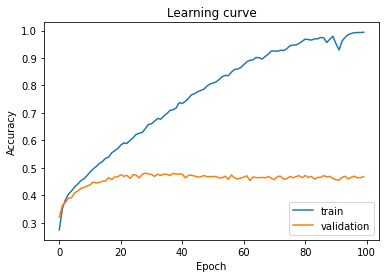

In [137]:
# Print tree depth, number of leaves and plot decision tree
if model_name == 'decision-tree':
    print(clf.get_depth(), clf.get_n_leaves())
    # tree.plot_tree(clf)
# Plot learning curve
elif model_name == 'neural-network':
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Learning curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')

## Evaluate the final model on the test set

In [138]:
# Predict on test set
test_X = pipeline.transform(test_set)
test_y = np.array(test_set['emotion'])

if model_name == 'neural-network':
    pred_y = clf.predict_classes(
        test_X,
        batch_size=model_hyper_parameters[model_name]['batch_size'],
        verbose=model_hyper_parameters[model_name]['verbose'],
    )
    pred_y = np.argmax(to_categorical(pred_y), axis=1)
else:
    pred_y = clf.predict(test_X)

4/4 [==============================] - 0s 40ms/step


In [139]:
# Evaluate on test set
print('Accuracy: {}'.format(accuracy_score(test_y, pred_y)))

Accuracy: 0.4878796322095291
